## Goal: Make anyone speak anything (LipSync)

* Github: https://github.com/Rudrabha/Wav2Lip
* Paper: https://arxiv.org/abs/2008.10010
*Original notebook: https://colab.research.google.com/drive/1tZpDWXz49W6wDcTprANRGLo2D_EbD5J8?usp=sharing




**Modded by: [justinjohn-03](https://github.com/justinjohn0306)**





In [ ]:
#@title <h1>Step1: Setup Wav2Lip</h1>
#@markdown * Install dependency
#@markdown * Download pretrained model
from IPython.display import HTML, clear_output
!rm -rf /content/sample_data
!mkdir /content/sample_data

!git clone https://github.com/justinjohn0306/Wav2Lip

%cd /content/Wav2Lip

#download the pretrained model
!wget 'https://github.com/justinjohn0306/Wav2Lip/releases/download/models/wav2lip.pth' -O 'checkpoints/wav2lip.pth'
!wget 'https://github.com/justinjohn0306/Wav2Lip/releases/download/models/wav2lip_gan.pth' -O 'checkpoints/wav2lip_gan.pth'
!wget 'https://github.com/justinjohn0306/Wav2Lip/releases/download/models/resnet50.pth' -O 'checkpoints/resnet50.pth'
!wget 'https://github.com/justinjohn0306/Wav2Lip/releases/download/models/mobilenet.pth' -O 'checkpoints/mobilenet.pth'
a = !pip install https://raw.githubusercontent.com/AwaleSajil/ghc/master/ghc-1.0-py3-none-any.whl
!pip install git+https://github.com/elliottzheng/batch-face.git@master

!pip install ffmpeg-python mediapipe==0.10.18

#this code for recording audio
"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

%cd /
from ghc.l_ghc_cf import l_ghc_cf
%cd content

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr


from IPython.display import HTML
from base64 import b64encode
def showVideo(path):
  mp4 = open(str(path),'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=700 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url)

from IPython.display import clear_output

clear_output()
print("All set and ready!")

# LipSync Youtube Video

In [ ]:
#@title STEP2: Select a Youtube Video
# Install yt-dlp

import os
!pip install yt-dlp

#@markdown ## Find YouTube video ID from URL

#@markdown ___

#@markdown Link format:

#@markdown ``https://youtu.be/vAnWYLTdvfY`` ❌

#@markdown ``https://www.youtube.com/watch?v=vAnWYLTdvfY`` ✔️

!rm -df youtube.mp4

#@markdown ___
from urllib import parse as urlparse
YOUTUBE_URL = 'https://www.youtube.com/watch?v=vAnWYLTdvfY' #@param {type:"string"}
url_data = urlparse.urlparse(YOUTUBE_URL)
query = urlparse.parse_qs(url_data.query)
YOUTUBE_ID = query["v"][0]


# remove previous input video
!rm -f /content/sample_data/input_vid.mp4


#@markdown ___

#@markdown ### Trim the video (start, end) seconds
start = 35 #@param {type:"integer"}
end = 62 #@param {type:"integer"}
interval = end - start

#@markdown <font color="orange"> Note: ``the trimmed video must have face on all frames``

# Download the YouTube video using yt-dlp
!yt-dlp -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID

# Cut the video using FFmpeg
!ffmpeg -y -i youtube.mp4 -ss {start} -t {interval} -async 1 /content/sample_data/input_vid.mp4

# Preview the trimmed video
from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/sample_data/input_vid.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""<video width=600 controls><source src="{data_url}"></video>""")



In [ ]:
#@title STEP3: Select Audio (Record, Upload from local drive or Gdrive)
import os
from IPython.display import Audio
from IPython.core.display import display

upload_method = 'Upload' #@param ['Record', 'Upload', 'Custom Path']

#remove previous input audio
if os.path.isfile('/content/sample_data/input_audio.wav'):
    os.remove('/content/sample_data/input_audio.wav')

def displayAudio():
  display(Audio('/content/sample_data/input_audio.wav'))

if upload_method == 'Record':
  audio, sr = get_audio()
  import scipy
  scipy.io.wavfile.write('/content/sample_data/input_audio.wav', sr, audio)

elif upload_method == 'Upload':
  from google.colab import files
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

  # Consider only the first file
  PATH_TO_YOUR_AUDIO = str(list(uploaded.keys())[0])

  # Load audio with specified sampling rate
  import librosa
  audio, sr = librosa.load(PATH_TO_YOUR_AUDIO, sr=None)

  # Save audio with specified sampling rate
  import soundfile as sf
  sf.write('/content/sample_data/input_audio.wav', audio, sr, format='wav')

  clear_output()
  displayAudio()

elif upload_method == 'Custom Path':
  from google.colab import drive
  drive.mount('/content/drive')
  #@markdown ``Add the full path to your audio on your Gdrive`` 👇
  PATH_TO_YOUR_AUDIO = '/content/drive/MyDrive/test.wav' #@param {type:"string"}

  # Load audio with specified sampling rate
  import librosa
  audio, sr = librosa.load(PATH_TO_YOUR_AUDIO, sr=None)

  # Save audio with specified sampling rate
  import soundfile as sf
  sf.write('/content/sample_data/input_audio.wav', audio, sr, format='wav')

  clear_output()
  displayAudio()


In [ ]:
#@title STEP4: Start Crunching and Preview Output
#@markdown <b>Note: Only change these, if you have to</b>

%cd /content/Wav2Lip

# Set up paths and variables for the output file
output_file_path = '/content/Wav2Lip/results/result_voice.mp4'

# Delete existing output file before processing, if any
if os.path.exists(output_file_path):
    os.remove(output_file_path)

pad_top =  0#@param {type:"integer"}
pad_bottom =  10#@param {type:"integer"}
pad_left =  0#@param {type:"integer"}
pad_right =  0#@param {type:"integer"}
rescaleFactor =  1#@param {type:"integer"}
nosmooth = True #@param {type:"boolean"}
#@markdown ___
#@markdown Model selection:
use_hd_model = False #@param {type:"boolean"}
checkpoint_path = 'checkpoints/wav2lip.pth' if not use_hd_model else 'checkpoints/wav2lip_gan.pth'


if nosmooth == False:
  !python inference.py --checkpoint_path $checkpoint_path --face "../sample_data/input_vid.mp4" --audio "../sample_data/input_audio.wav" --pads $pad_top $pad_bottom $pad_left $pad_right --resize_factor $rescaleFactor
else:
  !python inference.py --checkpoint_path $checkpoint_path --face "../sample_data/input_vid.mp4" --audio "../sample_data/input_audio.wav" --pads $pad_top $pad_bottom $pad_left $pad_right --resize_factor $rescaleFactor --nosmooth

#Preview output video
if os.path.exists(output_file_path):
    clear_output()
    print("Final Video Preview")
    print("Download this video from", output_file_path)
    showVideo(output_file_path)
else:
    print("Processing failed. Output video not found.")

# LipSync on Your Video File

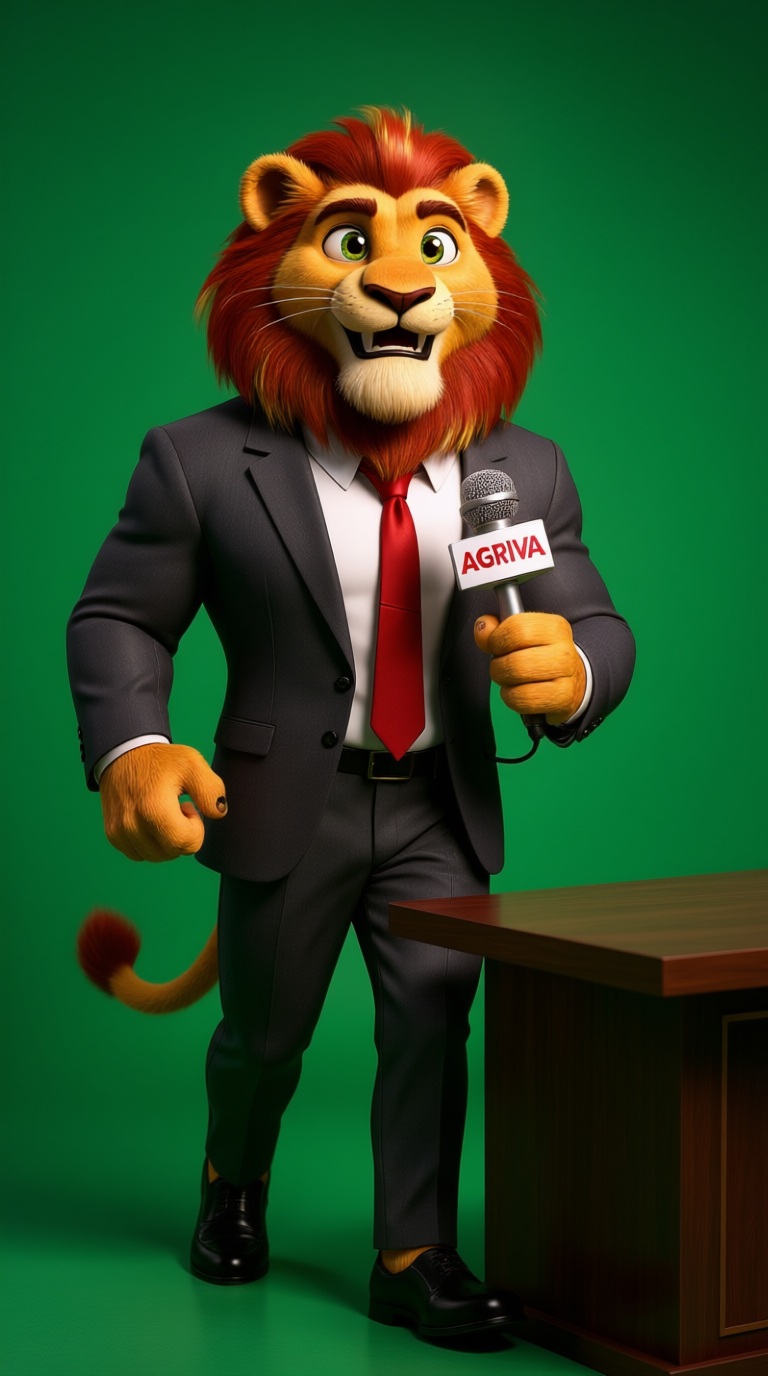

In [ ]:
import os
import shutil
from google.colab import drive
from google.colab import files
from IPython.display import HTML, clear_output
from base64 import b64encode
import moviepy.editor as mp


def showVideo(file_path):
    """Function to display video in Colab"""
    mp4 = open(file_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(HTML("""
    <video controls width=600>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url))

def get_video_resolution(video_path):
    """Function to get the resolution of a video"""
    import cv2
    video = cv2.VideoCapture(video_path)
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    return (width, height)

def resize_video(video_path, new_resolution):
    """Function to resize a video"""
    import cv2
    video = cv2.VideoCapture(video_path)
    fourcc = int(video.get(cv2.CAP_PROP_FOURCC))
    fps = video.get(cv2.CAP_PROP_FPS)
    width, height = new_resolution
    output_path = os.path.splitext(video_path)[0] + '_720p.mp4'
    writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    while True:
        success, frame = video.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, new_resolution)
        writer.write(resized_frame)
    video.release()
    writer.release()

# Mount Google Drive if it's not already mounted
if not os.path.isdir("/content/drive/MyDrive"):
    drive.mount('/content/drive', force_remount=True)

#@markdown ### Select an uploading method
upload_method = "Upload" #@param ["Upload", "Custom Path"]


# remove previous input video
if os.path.isfile('/content/sample_data/input_vid.mp4'):
    os.remove('/content/sample_data/input_vid.mp4')

if upload_method == "Upload":
    uploaded = files.upload()
    for filename in uploaded.keys():
        os.rename(filename, '/content/sample_data/input_vid.mp4')
    PATH_TO_YOUR_VIDEO = '/content/sample_data/input_vid.mp4'

elif upload_method == 'Custom Path':
    #@markdown ``Add the full path to your video on your Gdrive `` 👇
    PATH_TO_YOUR_VIDEO = '/content/drive/MyDrive/test.mp4' #@param {type:"string"}
    if not os.path.isfile(PATH_TO_YOUR_VIDEO):
        print("ERROR: File not found!")
        raise SystemExit(0)

#@markdown <font color="orange">Notes:

#@markdown <font color="orange">. ``If your uploaded video is 1080p or higher resolution, this cell will resize it to 720p.``

#@markdown <font color="orange">. ``Do not upload videos longer than 60 seconds.``

#@markdown ___

video_duration = mp.VideoFileClip(PATH_TO_YOUR_VIDEO).duration
if video_duration > 60:
    print("WARNING: Video duration exceeds 60 seconds. Please upload a shorter video.")
    raise SystemExit(0)

video_resolution = get_video_resolution(PATH_TO_YOUR_VIDEO)
print(f"Video resolution: {video_resolution}")
if video_resolution[0] >= 1920 or video_resolution[1] >= 1080:
    print("Resizing video to 720p...")
    os.system(f"ffmpeg -i {PATH_TO_YOUR_VIDEO} -vf scale=1280:720 /content/sample_data/input_vid.mp4")
    PATH_TO_YOUR_VIDEO = "/content/sample_data/input_vid.mp4"
    print("Video resized to 720p")
else:
    print("No resizing needed")

if upload_method == "Upload":
  clear_output()
  print("Input Video")
  showVideo(PATH_TO_YOUR_VIDEO)
else:
    if os.path.isfile(PATH_TO_YOUR_VIDEO):
        # Check if the source and destination files are the same
        if PATH_TO_YOUR_VIDEO != "/content/sample_data/input_vid.mp4":
            shutil.copyfile(PATH_TO_YOUR_VIDEO, "/content/sample_data/input_vid.mp4")
            print("Video copied to destination.")

        print("Input Video")
        # Display the video from the destination path
        showVideo("/content/sample_data/input_vid.mp4")

In [ ]:
#@title STEP3: Select Audio (Record, Upload from local drive or Gdrive)
import os
from IPython.display import Audio
from IPython.core.display import display

upload_method = 'Upload' #@param ['Record', 'Upload', 'Custom Path']

#remove previous input audio
if os.path.isfile('/content/sample_data/input_audio.wav'):
    os.remove('/content/sample_data/input_audio.wav')

def displayAudio():
  display(Audio('/content/sample_data/input_audio.wav'))

if upload_method == 'Record':
  audio, sr = get_audio()
  import scipy
  scipy.io.wavfile.write('/content/sample_data/input_audio.wav', sr, audio)

elif upload_method == 'Upload':
  from google.colab import files
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes.'.format(
        name=fn, length=len(uploaded[fn])))

  # Consider only the first file
  PATH_TO_YOUR_AUDIO = str(list(uploaded.keys())[0])

  # Load audio with specified sampling rate
  import librosa
  audio, sr = librosa.load(PATH_TO_YOUR_AUDIO, sr=None)

  # Save audio with specified sampling rate
  import soundfile as sf
  sf.write('/content/sample_data/input_audio.wav', audio, sr, format='wav')

  clear_output()
  displayAudio()

else: # Custom Path
  from google.colab import drive
  drive.mount('/content/drive')
  #@markdown ``Add the full path to your audio on your Gdrive`` 👇
  PATH_TO_YOUR_AUDIO = '/content/drive/MyDrive/test.wav' #@param {type:"string"}

  # Load audio with specified sampling rate
  import librosa
  audio, sr = librosa.load(PATH_TO_YOUR_AUDIO, sr=None)

  # Save audio with specified sampling rate
  import soundfile as sf
  sf.write('/content/sample_data/input_audio.wav', audio, sr, format='wav')

  clear_output()
  displayAudio()


In [ ]:
#@title STEP4: Start Crunching and Preview Output
#@markdown <b>Note: Only change these, if you have to</b>

%cd /content/Wav2Lip

# Set up paths and variables for the output file
output_file_path = '/content/Wav2Lip/results/result_voice.mp4'

# Delete existing output file before processing, if any
if os.path.exists(output_file_path):
    os.remove(output_file_path)

pad_top =  0#@param {type:"integer"}
pad_bottom =  10#@param {type:"integer"}
pad_left =  0#@param {type:"integer"}
pad_right =  0#@param {type:"integer"}
rescaleFactor =  1#@param {type:"integer"}
nosmooth = True #@param {type:"boolean"}
#@markdown ___
#@markdown Model selection:
use_hd_model = False #@param {type:"boolean"}
checkpoint_path = 'checkpoints/wav2lip.pth' if not use_hd_model else 'checkpoints/wav2lip_gan.pth'


if nosmooth == False:
  !python inference.py --checkpoint_path $checkpoint_path --face "../sample_data/input_vid.mp4" --audio "../sample_data/input_audio.wav" --pads $pad_top $pad_bottom $pad_left $pad_right --resize_factor $rescaleFactor
else:
  !python inference.py --checkpoint_path $checkpoint_path --face "../sample_data/input_vid.mp4" --audio "../sample_data/input_audio.wav" --pads $pad_top $pad_bottom $pad_left $pad_right --resize_factor $rescaleFactor --nosmooth

#Preview output video
if os.path.exists(output_file_path):
    clear_output()
    print("Final Video Preview")
    print("Download this video from", output_file_path)
    showVideo(output_file_path)
else:
    print("Processing failed. Output video not found.")